In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:

import pandas as pd
import numpy as np

import requests
import bs4
from bs4 import BeautifulSoup
import time
from tqdm import tqdm
import math


from collections import defaultdict
import regex as re
import datetime


   Pos                 Driver Nationality           Car  PTS
0    1         James Hunt HUN         GBR  McLaren Ford   69
1    2         Niki Lauda LAU         AUT       Ferrari   68
2    3     Jody Scheckter SCH         RSA  Tyrrell Ford   49
3    4  Patrick Depailler DEP         FRA  Tyrrell Ford   39
4    5     Clay Regazzoni REG         SUI       Ferrari   31


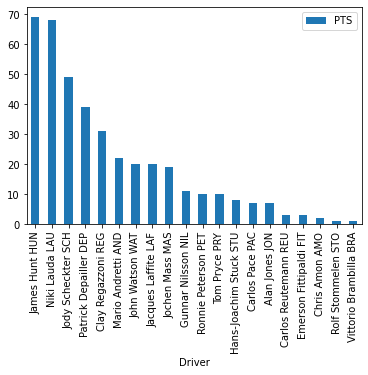

In [11]:

# libraries needed for BS and urllib
from six.moves import urllib
import bs4 as bs
import urllib.request

source = urllib.request.urlopen('https://www.formula1.com/en/results.html/1976/drivers.html').read()
soup = bs.BeautifulSoup(source,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.drop(["Unnamed: 0","Unnamed: 6"],axis=1, inplace=True)
print(df.head())
df.plot.bar(x="Driver", y="PTS");

   Pos               Driver Nationality                    Car    PTS
0    1   Max Verstappen VER         NED  Red Bull Racing Honda  395.5
1    2   Lewis Hamilton HAM         GBR               Mercedes  387.5
2    3  Valtteri Bottas BOT         FIN               Mercedes  226.0
3    4     Sergio Perez PER         MEX  Red Bull Racing Honda  190.0
4    5     Carlos Sainz SAI         ESP                Ferrari  164.5


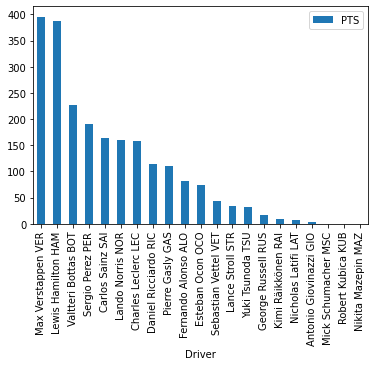

In [12]:


# libraries needed for BS and urllib
from six.moves import urllib
import bs4 as bs
import urllib.request

source = urllib.request.urlopen('https://www.formula1.com/en/results.html/2021/drivers.html').read()
soup = bs.BeautifulSoup(source,'lxml')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.drop(["Unnamed: 0","Unnamed: 6"],axis=1, inplace=True)
print(df.head())
df.plot.bar(x="Driver", y="PTS");


In [13]:

"""
Let's look at a single race result from that season
""" 
source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/2021/races/1067/monaco/race-result.html").read()
soup = bs.BeautifulSoup(source,'lxml')

table = soup.find_all('table')[0] 
df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
df.drop(["Unnamed: 0","Unnamed: 8"],axis=1, inplace=True)
df.head()

,Pos,No,Driver,Car,Laps,Time/Retired,PTS
0,1,33,Max Verstappen VER,Red Bull Racing Honda,78,1:38:56.820,25
1,2,55,Carlos Sainz SAI,Ferrari,78,+8.968s,18
2,3,4,Lando Norris NOR,McLaren Mercedes,78,+19.427s,15
3,4,11,Sergio Perez PER,Red Bull Racing Honda,78,+20.490s,12
4,5,5,Sebastian Vettel VET,Aston Martin Mercedes,78,+52.591s,10


In [14]:

def get_race_urls(YEAR):
    race_urls = []
    
    source = urllib.request.urlopen(f"https://www.formula1.com/en/results.html/{YEAR}/races.html").read()
    soup = bs.BeautifulSoup(source,'lxml')
    
    for url in soup.find_all('a'):
        if YEAR in str(url.get('href')) and 'race-result' in str(url.get('href')) and url.get('href') not in race_urls:
            race_urls.append(url.get('href'))
    return race_urls

In [15]:

get_race_urls("2021")

['/en/results.html/2021/races/1064/bahrain/race-result.html',
 '/en/results.html/2021/races/1065/italy/race-result.html',
 '/en/results.html/2021/races/1066/portugal/race-result.html',
 '/en/results.html/2021/races/1086/spain/race-result.html',
 '/en/results.html/2021/races/1067/monaco/race-result.html',
 '/en/results.html/2021/races/1068/azerbaijan/race-result.html',
 '/en/results.html/2021/races/1070/france/race-result.html',
 '/en/results.html/2021/races/1092/austria/race-result.html',
 '/en/results.html/2021/races/1071/austria/race-result.html',
 '/en/results.html/2021/races/1072/great-britain/race-result.html',
 '/en/results.html/2021/races/1073/hungary/race-result.html',
 '/en/results.html/2021/races/1074/belgium/race-result.html',
 '/en/results.html/2021/races/1075/netherlands/race-result.html',
 '/en/results.html/2021/races/1076/italy/race-result.html',
 '/en/results.html/2021/races/1077/russia/race-result.html',
 '/en/results.html/2021/races/1078/turkey/race-result.html',
 '/e

In [18]:

race_urls = get_race_urls("2021")
season_results_df = None

'''@timer'''
def seasons_results(race_urls):

    for n, race in enumerate(race_urls):

        placeholder = [0 for i in range(n)]
        race_name = race.split('/')[6]

        results_page = urllib.request.urlopen(f"{HOMEPAGE}{race}").read()
        race_results = bs.BeautifulSoup(results_page,'lxml')

        table = race_results.find_all('table')[0] 
        df = pd.read_html(str(table), flavor='bs4', header=[0])[0]
        df.drop(["Unnamed: 0","Unnamed: 8"], axis=1, inplace=True)
        df.set_index('No', inplace=True)

        #establish season results df on first race information
        if n == 0:
            season_results_df = pd.DataFrame(df[['Driver','Car']], columns=['Driver','Car'], index=df.index)
       
        #add drivers if they are not in season_results_df
        for ind in df.index.difference(season_results_df.index):
            season_results_df.loc[ind] = [df['Driver'].loc[ind],df['Car'].loc[ind],*placeholder]

        for ind in df.index:
            pts = df['PTS'].where(df.index == ind).dropna().values[0]
            season_results_df.loc[ind, race_name] = int(pts)
    
    #####Format the dataframe with a few lines#####
    season_results_df.sort_index(inplace=True)
    season_results_df.fillna(0, inplace=True)   
    season_results_df['Car'] = season_results_df['Car'].apply(lambda s : s[:3]).map(str.upper) #retain last 3 digits and caps
    return season_results_df 